<a href="https://colab.research.google.com/github/UsamaMed/data_science/blob/main/Political_and_Leadership_Malaysia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q snscrape==0.3.4

In [ ]:
import nltk
nltk.downloader.download('vader_lexicon')
import os
import pandas as pd
import datetime as dt
from datetime import date
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
begin_date = dt.date(2023,2,1)
end_date = dt.date(2023,2,2)
search_term = 'Politics Malaysia'
limit = 1000

In [ ]:
os.system(f"snscrape --since {begin_date} twitter-search '{search_term} until:{end_date}' > result-tweets.txt")
if os.stat("result-tweets.txt").st_size == 0:
  counter = 0
else:
  df = pd.read_csv('result-tweets.txt', names=['link'])
  counter = df.size

print('Number Of Tweets : '+ str(counter))

Number Of Tweets : 27


In [ ]:
extracted_tweets = "snscrape --format '{content!r}'"+ f" --max-results {limit} --since {begin_date} twitter-search '{search_term} until:{end_date}' > extracted-tweets.txt"
os.system(extracted_tweets)
if os.stat("extracted-tweets.txt").st_size == 0:
  print('No Tweets found')
else:
  df = pd.read_csv('extracted-tweets.txt', names=['content'])
  for row in df['content'].iteritems():
    print(row)

(0, "'News on #Malaysia | Prime Minister Ibrahim is struggling to douse accusations of nepotism after appointing his daughter as a special adviser. He vowed would be a clean break from the country’s scandal-mired dynastic politics. https://t.co/L7ekfIG42s'")
(1, "Shared Strategic Needs Drive Brunei-Malaysia Ties - Analysis\\nhttps://t.co/9jEQCjDhUV\\nMalaysian Prime Minister Datuk Seri Anwar Ibrahim's recent visit to Brunei underscored the strategic importance of both countries to one another, especially in the field of high politics and ... https://t.co/RLXmENKdxO")
(2, "'cc. Tunku @HRHJohorII. \\n\\nWe just need the political will. Maybe Tunku being above politics can make Muar Bandar DiRaja the example city for public transport and accessibility/walkability in Malaysia. \\n🚌🚏👩\\u200d🦽  🚴\\u200d♂️🚶\\n@onnhafiz @SyedSaddiq @fazliSalleh4 @ydpmpmuar'")
(3, "'i hate global politics so much'")
(4, "'We need a local version of Cunk On Earth")
(5, "As a football fan, watching Kyle Shanahan 

In [ ]:
df = pd.read_csv('/content/politics and leadership.csv')
df.head(10)

,text
0,'News on #Malaysia | Prime Minister Ibrahim is...
1,"""Shared Strategic Needs Drive Brunei-Malaysia ..."
2,'cc. Tunku @HRHJohorII. \n\nWe just need the p...
3,'i hate global politics so much'
4,"'We need a local version of Cunk On Earth, pro..."
5,"""As a football fan, watching Kyle Shanahan gro..."
6,'MACC freezes bank accounts of Bersatu - Azam ...
7,'Elon Musk\nBulldogs\nAnita\nGen Z\nNoosa\nMal...
8,'Elon Musk\nBulldogs\nAnita\nGen Z\nNoosa\nMal...
9,'Interview by Joelle Aziz for Noursat English ...


In [ ]:
df.shape

(27, 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27 non-null     object
dtypes: object(1)
memory usage: 344.0+ bytes


In [ ]:
df.isnull().sum()

text    0
dtype: int64

In [ ]:
df.columns

Index(['text'], dtype='object')

In [ ]:
#df = df.rename(columns={'https://twitter.com/ctkusut/status/1620209601080885248': 'text'})
#df.head()

In [ ]:
#df.drop(columns=['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'], inplace=True)

In [ ]:
df.text =df.text.str.lower()
#Remove twitter handlers
df.text = df.text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
df.text = df.text.apply(lambda x:re.sub(r'\B#\S+','',x))


# Remove URLS
df.text = df.text.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
df.text = df.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
df.text = df.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
df.text = df.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [ ]:
sid = SIA()
df['sentiments']           = df['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
df['Positive Sentiment']   = df['sentiments'].apply(lambda x: x['pos']+1*(10**-6))
df['Neutral Sentiment']    = df['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
df['Negative Sentiment']   = df['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

df.drop(columns=['sentiments'],inplace=True)

In [ ]:
#Number of Words
df['Number_Of_Words'] = df.text.apply(lambda x:len(x.split(' ')))
#Average Word Length
df['Mean_Word_Length'] = df.text.apply(lambda x:np.round(np.mean([len(w) for w in x.split(' ')]),2) )

In [ ]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
df['polarity'] = df['text'].apply(polarity)

In [ ]:
df.head(10)

,text,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Number_Of_Words,Mean_Word_Length,polarity
0,news on prime minister ibrahim is struggling t...,0.000001,0.841001,0.159001,29,6.03,0.000
1,shared strategic needs drive brunei malaysia t...,0.133001,0.867001,0.000001,34,5.91,0.080
2,cc tunkunwe just need the political will maybe...,0.000001,1.000001,0.000001,37,5.03,0.000
3,i hate global politics so much,0.000001,0.519001,0.481001,6,4.17,-0.200
4,we needlocal version of cunk on earth probably...,0.000001,1.000001,0.000001,35,5.20,0.000
5,asfootball fan watching kyle shanahan grow und...,0.208001,0.792001,0.000001,37,5.35,0.245
6,macc freezes bank accounts of bersatu azam bak...,0.000001,0.879001,0.121001,9,5.56,0.000
7,elon musk nbulldogs nanita ngennnoosa nmalaysi...,0.000001,1.000001,0.000001,20,8.05,0.000
8,elon musk nbulldogs nanita ngennnoosa nmalaysi...,0.000001,1.000001,0.000001,20,8.05,0.000
9,interview by joelle aziz for noursat english t...,0.225001,0.775001,0.000001,34,5.47,0.195


In [ ]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [ ]:
df['sentiment'] = df['polarity'].apply(sentiment)

In [ ]:
df.head()

,text,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Number_Of_Words,Mean_Word_Length,polarity,sentiment
0,news on prime minister ibrahim is struggling t...,0.000001,0.841001,0.159001,29,6.03,0.00,Neutral
1,shared strategic needs drive brunei malaysia t...,0.133001,0.867001,0.000001,34,5.91,0.08,Positive
2,cc tunkunwe just need the political will maybe...,0.000001,1.000001,0.000001,37,5.03,0.00,Neutral
3,i hate global politics so much,0.000001,0.519001,0.481001,6,4.17,-0.20,Negative
4,we needlocal version of cunk on earth probably...,0.000001,1.000001,0.000001,35,5.20,0.00,Neutral


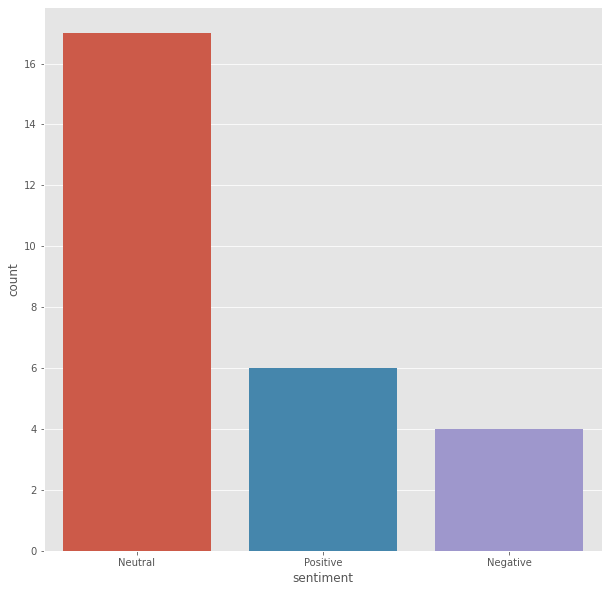

In [ ]:
fig = plt.figure(figsize=(10,10))
sns.countplot(x='sentiment', data = df)

Text(0.5, 1.0, 'Distribution of sentiments')

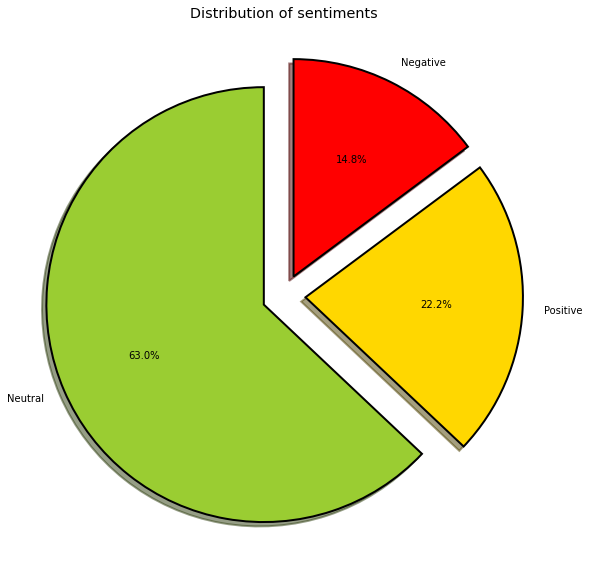

In [ ]:
fig = plt.figure(figsize=(10,10))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [ ]:
pos_tweets = df[df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

,text,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Number_Of_Words,Mean_Word_Length,polarity,sentiment
11,its been almost 4 years sinceleft uia asstuden...,0.179001,0.729001,0.092001,46,4.72,0.250,Positive
5,asfootball fan watching kyle shanahan grow und...,0.208001,0.792001,0.000001,37,5.35,0.245,Positive
13,pening malaysia must move on and focus on econ...,0.000001,0.935001,0.065001,47,4.21,0.200,Positive
26,what zahid and umno are really up to with kj e...,0.000001,1.000001,0.000001,13,3.62,0.200,Positive
9,interview by joelle aziz for noursat english t...,0.225001,0.775001,0.000001,34,5.47,0.195,Positive


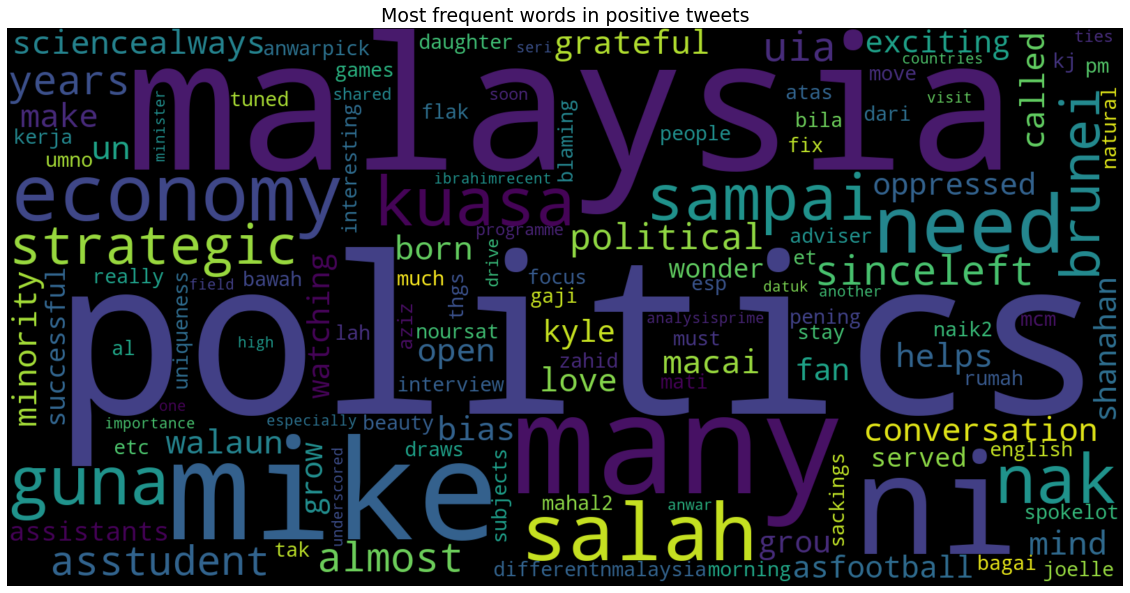

In [ ]:
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [ ]:
neg_tweets = df[df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

,text,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Number_Of_Words,Mean_Word_Length,polarity,sentiment
14,1 of 3 pakistan can learnlot from other muslim...,0.081001,0.919001,0.000001,47,4.64,-0.062500,Negative
15,bolsonaro vows to remain active in brazilian p...,0.278001,0.722001,0.000001,8,5.75,-0.133333,Negative
3,i hate global politics so much,0.000001,0.519001,0.481001,6,4.17,-0.200000,Negative
17,tun faisal who was suspended in 2021 said he h...,0.000001,0.881001,0.119001,24,4.58,-0.263889,Negative


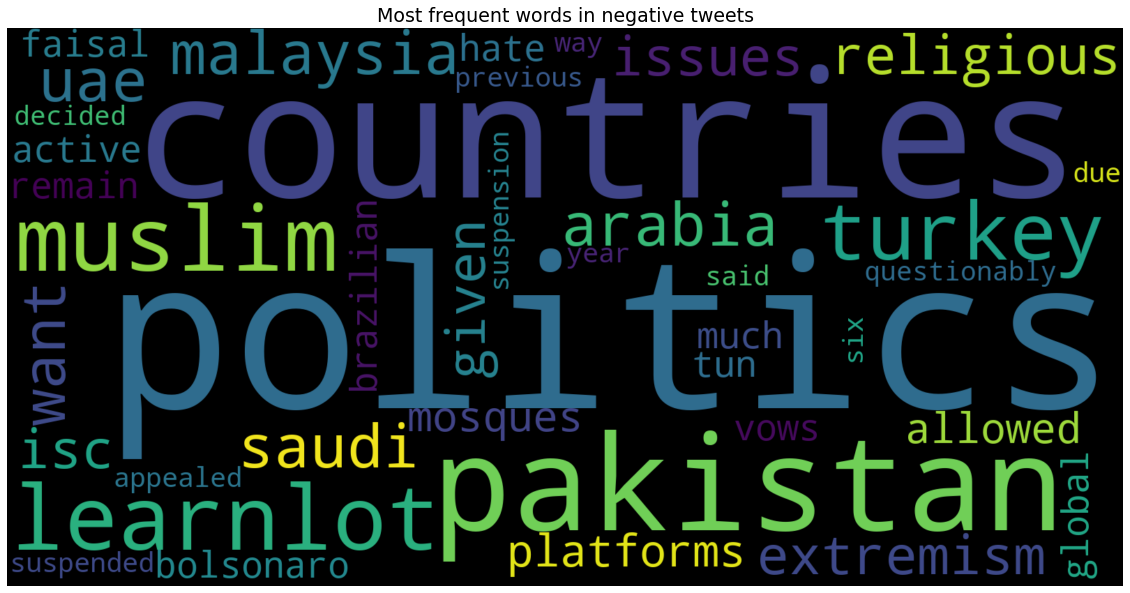

In [ ]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

In [ ]:
neutral_tweets = df[df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
neutral_tweets.head()

,text,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Number_Of_Words,Mean_Word_Length,polarity,sentiment
0,news on prime minister ibrahim is struggling t...,0.000001,0.841001,0.159001,29,6.03,0.0,Neutral
18,alert macc freezes bersatu bank account report,0.265001,0.602001,0.133001,7,5.71,0.0,Neutral
24,ph try to uphold non race party that is why th...,0.185001,0.815001,0.000001,41,4.76,0.0,Neutral
23,the plaintiff is seeking to compel the defenda...,0.000001,0.823001,0.177001,22,5.32,0.0,Neutral
22,bangladesh berharap malaysia mengamalkan siste...,0.000001,1.000001,0.000001,23,6.74,0.0,Neutral


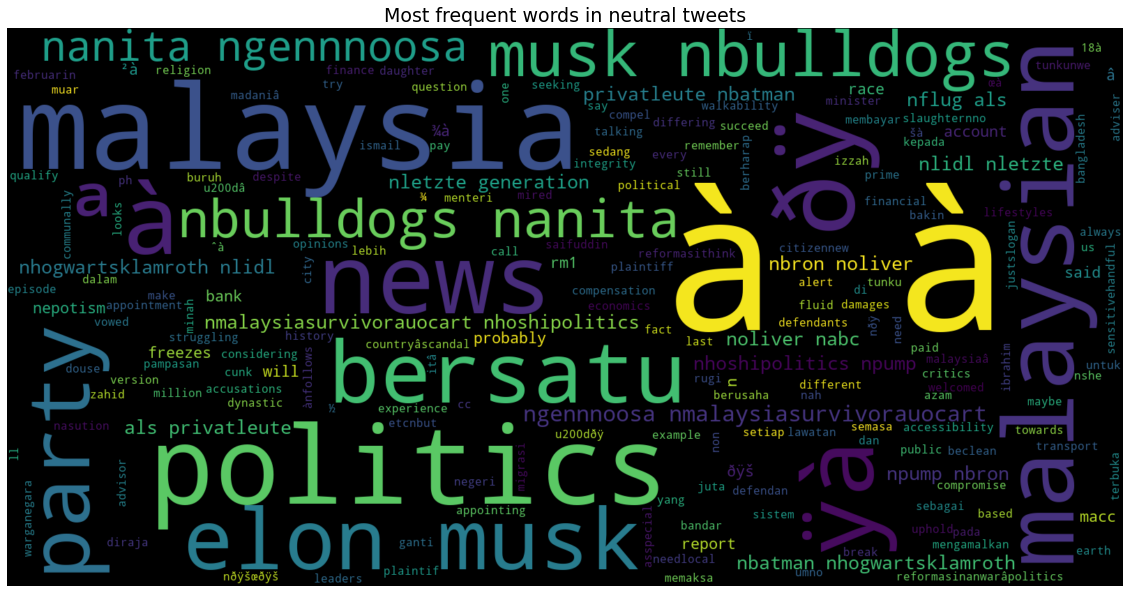

In [ ]:
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()